In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys import ecephys_session
%matplotlib inline

# fix slow autocomplete
%config Completer.use_jedi = False

In [2]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # OS X 
    data_root = "/Volumes/Brain2019/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2019/"

manifest_path = os.path.join(data_root, "dynamic-brain-workshop/visual_coding_neuropixels/2019/manifest.json")

In [3]:
cache = EcephysProjectCache.fixed(manifest=manifest_path)
sessions = cache.get_sessions()

In [4]:
hcareas = ['CA','DG']

hc_sessions = []
for i in np.arange(len(sessions.structure_acronyms)):
    sessionid = sessions.structure_acronyms.index[i]
    if any(elem in sessions.structure_acronyms[sessionid] for elem in hcareas):
        hc_sessions.append(sessionid)

In [5]:
hc_sessions_info = sessions[sessions.index == hc_sessions]

In [6]:
allunits = cache.get_units(hc_sessions)

In [7]:
channelinfo = cache.get_channels()

In [8]:
probeinfo = cache.get_probes()

In [9]:
ca_channelinfo = channelinfo[channelinfo.manual_structure_acronym == "CA"]
ca_units = allunits[allunits.peak_channel_id.isin(ca_channelinfo.index)]

dg_channelinfo = channelinfo[channelinfo.manual_structure_acronym == "DG"]
dg_units = allunits[allunits.peak_channel_id.isin(dg_channelinfo.index)]

In [10]:
sessionid = sessions.index[0]
session_info = cache.get_session_data(sessionid)
probeid = session_info.probes.index[0]

In [11]:
probe_lfp = session_info.get_lfp(probeid)

In [12]:
ca_channels_lfp = probe_lfp.loc[dict(channel=probe_lfp.channel.isin(ca_channelinfo.index))]

In [13]:
# spike_times = session_info.spike_times
# unit_id = session_info.units[session.units.structure_acronym=='VISp'].index[12]
# spikes = spike_times[unit_id]
# numbins = int(np.ceil(spikes.max()))

<b>INDIVIDUAL CA1 CELLS FIRING RATES ACROSS STIMULI</b>

In [14]:
session = session_info

In [15]:
#CALCULATE NUMBINS
spike_times = session.spike_times
unit_id = session.units[session.units.structure_acronym=='VISp'].index[12]
spikes = spike_times[unit_id]
numbins = int(np.ceil(spikes.max()))

In [16]:
ca_units = session.units[session.units.structure_acronym=='CA']
numunits = len(ca_units)
# if numunits>50:
#     numunits=50
ca_binned = np.empty((numunits, numbins))
for i in range(numunits):
    unit_id = ca_units.index[i]
    spikes = spike_times[unit_id]
    for j in range(numbins):
        ca_binned[i,j] = len(spikes[(spikes>j)&(spikes<j+1)]) 

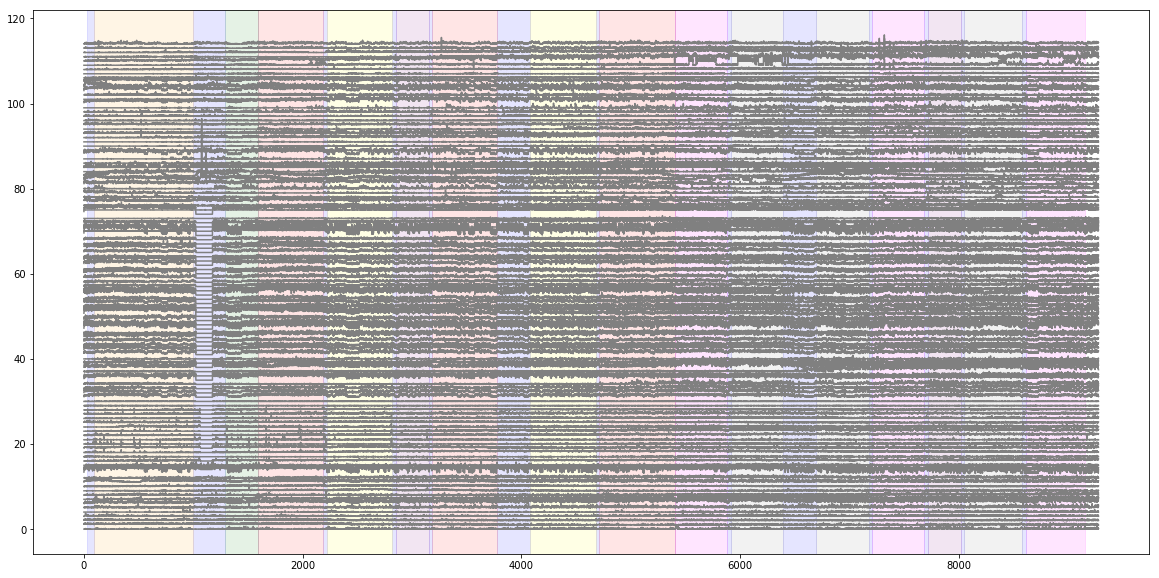

In [20]:
stimulus_epochs = session.get_stimulus_epochs()
# %matplotlib notebook
plt.figure(figsize=(20,10))
for i in range(numunits):
    plt.plot(i+(ca_binned[i,:]/30.), color='gray')

colors = ['blue','orange','green','red','yellow','purple','magenta','gray','lightblue']
for c, stim_name in enumerate(session.stimulus_names):
    stim = stimulus_epochs[stimulus_epochs.stimulus_name==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim["start_time"].iloc[j], xmax=stim["stop_time"].iloc[j], color=colors[c], alpha=0.1)

plotname = 'CA_firingrates' + str(sessionid) + '_probe' + str(probeid) + '.png'
filename = os.path.abspath(os.getcwd()+'/../buzsaki_plots/'+ plotname)
plt.savefig(filename,dpi=300)

<b>PLOT POPULATION RATE, RUNNING SPEED, AND LFP </b>

In [21]:
ca_channels_lfp

<xarray.DataArray 'LFP' (time: 11596665, channel: 10)>
array([[ 167,  112,  101, ...,   12,  -28,   16],
       [ 146,  178,  -73, ..., -109, -168, -146],
       [ 372,  241,  -47, ..., -247, -260, -188],
       ...,
       [ 579,  320,  741, ...,  333,  267,   19],
       [ 577,  358,  651, ...,  347,  231,  -74],
       [ 304,  187,  284, ...,  138,   24, -169]], dtype=int16)
Coordinates:
  * time     (time) float64 0.5577 0.5585 0.5593 ... 9.278e+03 9.278e+03
  * channel  (channel) int64 850217645 850217653 ... 850217709 850217717

In [22]:
ca_channels_lfp.time.values

array([5.57689086e-01, 5.58489087e-01, 5.59289088e-01, ...,
       9.27789647e+03, 9.27789727e+03, 9.27789807e+03])

In [23]:
channelid = ca_channels_lfp["channel"].values[0]

In [30]:
import scipy.signal

t = ca_channels_lfp.time.values
v = ca_channels_lfp[:,0].values

freq_window = (6, 12)
filt_order = 3
fs = 1/(t[1]-t[0])
b, a = scipy.signal.butter(filt_order, freq_window, btype='bandpass', fs=fs)
v_alpha = scipy.signal.lfilter(b, a, v)

<IPython.core.display.Javascript object>


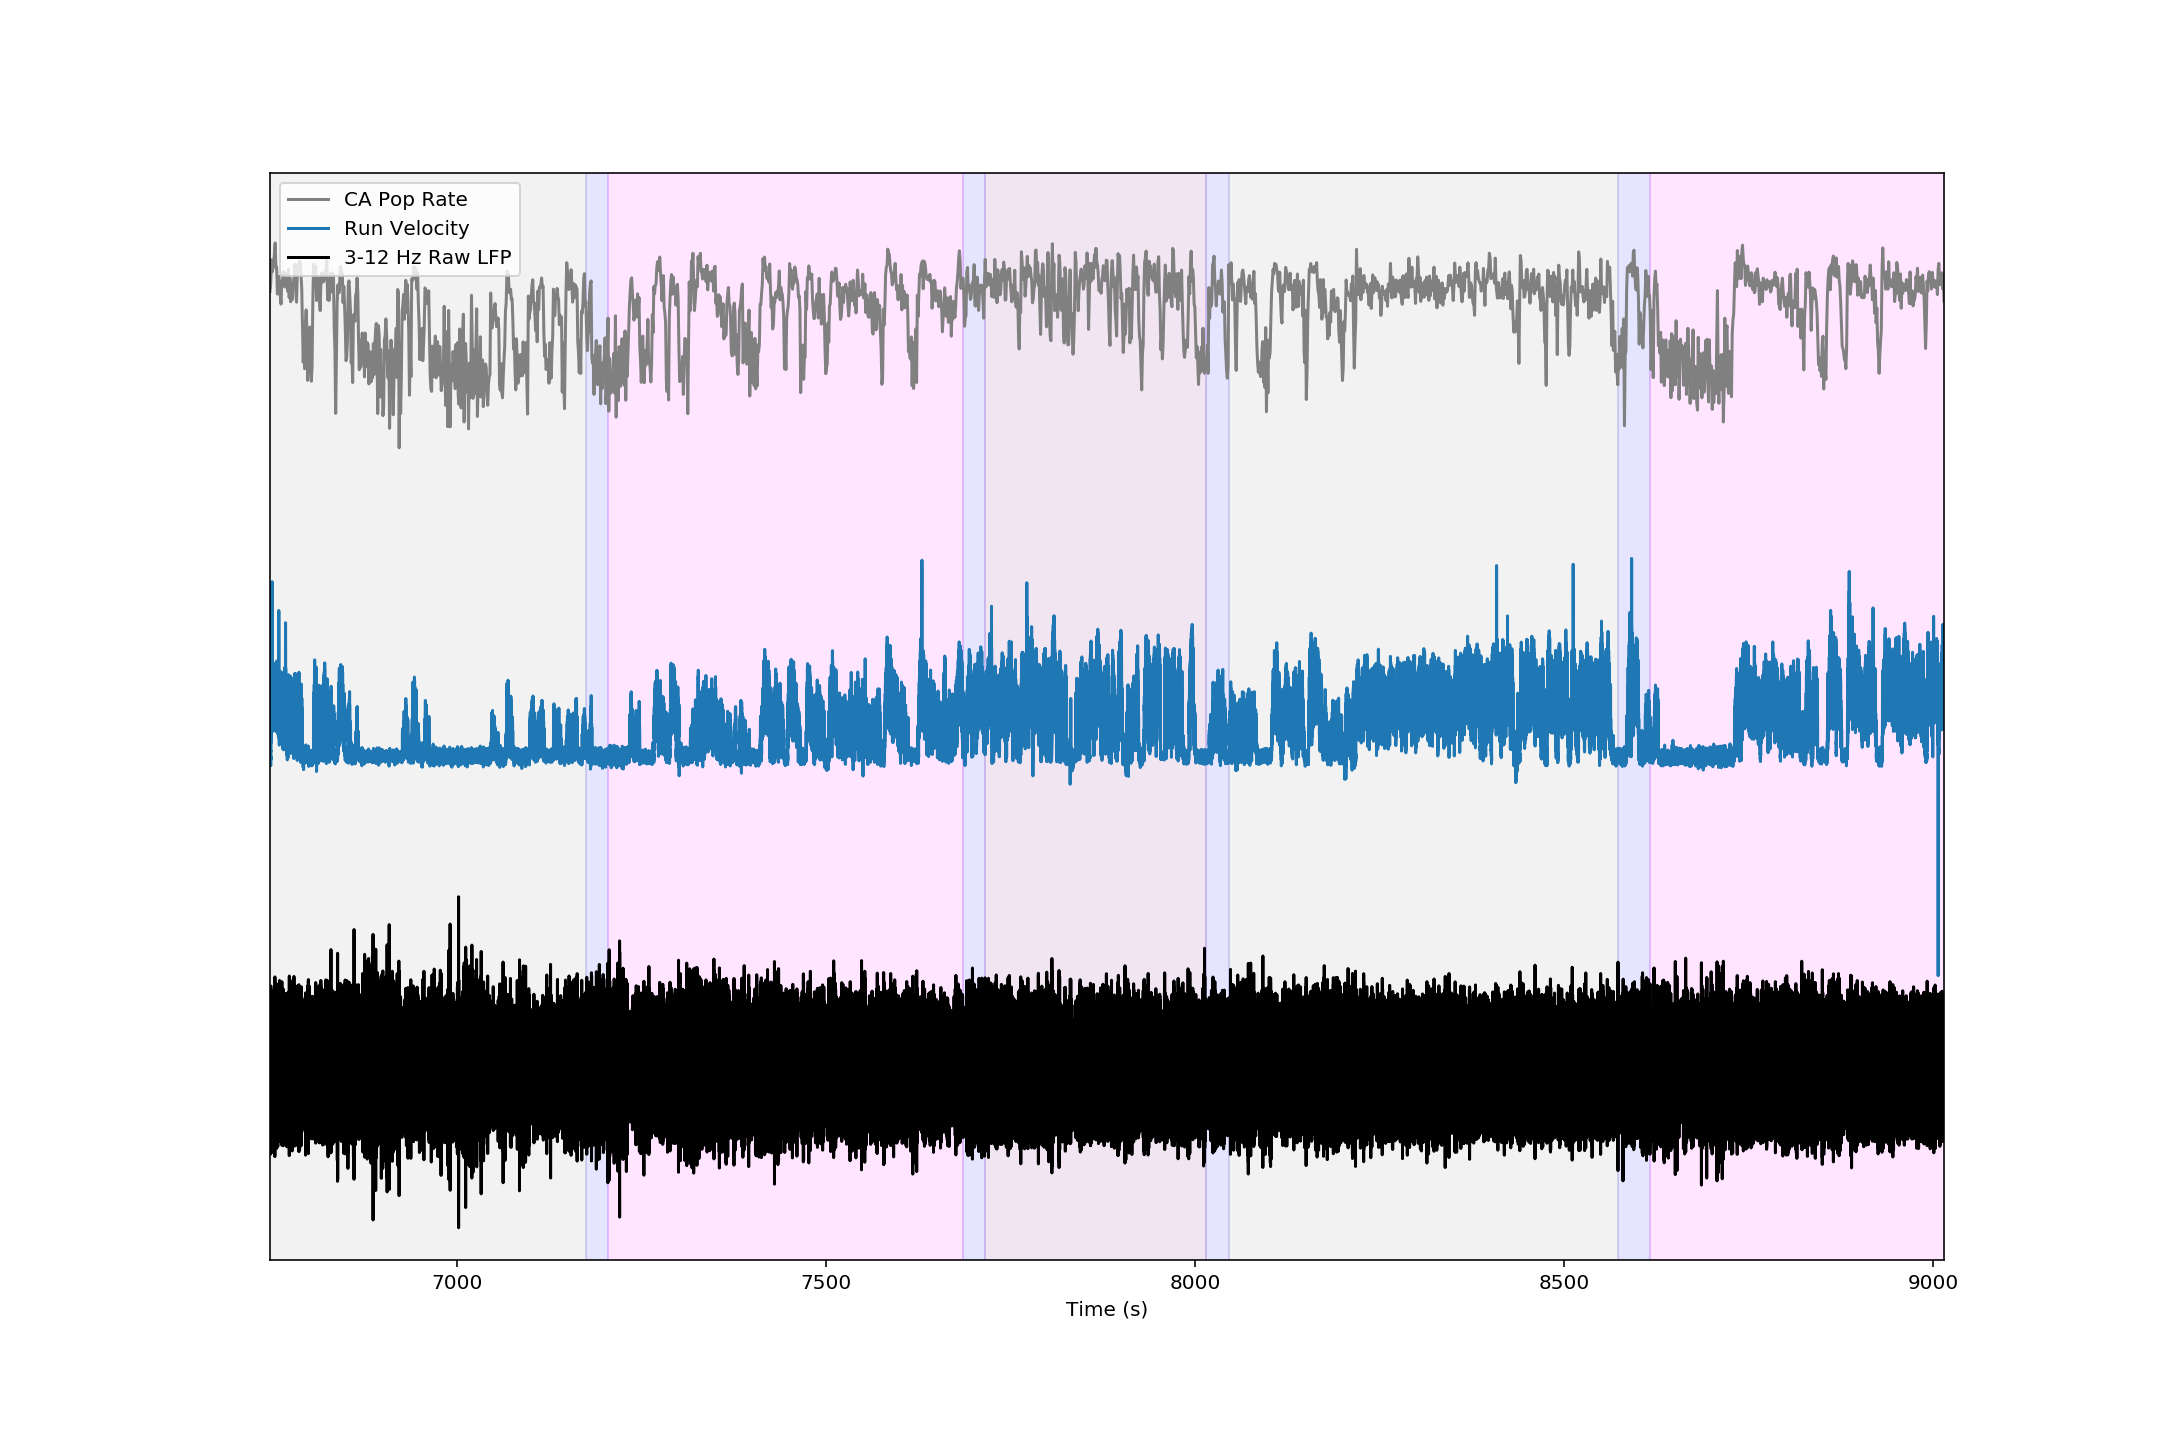

In [64]:
%matplotlib notebook
pop_binned = np.mean(ca_binned,axis=0)

plt.figure(figsize=(15,10))
    
plt.plot(pop_binned,color='gray',label='CA Pop Rate')

colors = ['blue','orange','green','red','yellow','purple','magenta','gray','lightblue']
for c, stim_name in enumerate(session.stimulus_names):
    stim = stimulus_epochs[stimulus_epochs.stimulus_name==stim_name]
#     plt.text(stim["start_time"],12,stim_name)
    for j in range(len(stim)):
        plt.axvspan(xmin=stim["start_time"].iloc[j], xmax=stim["stop_time"].iloc[j], color=colors[c], alpha=0.1)
        
plt.plot(session.running_speed.end_time, (0.1*session.running_speed.velocity)-10,label = 'Run Velocity')
# plt.plot(session.running_speed.end_time, (0.1*binned_run)-10,label = 'Run Velocity')

plt.plot(t, 0.003*v_alpha - 25,'k', label='3-12 Hz Raw LFP')

plt.legend(loc='upper left')
plt.yticks([])
plt.xlabel('Time (s)')

plotname = 'CA_poprate_runspeed_theta_sesssion' + str(sessionid) + '_probe' + str(probeid) + '_chan' + str(channelid) + '.png'
filename = os.path.abspath(os.getcwd()+'/../buzsaki_plots/'+ plotname)
# plt.savefig(filename,dpi=300)

<IPython.core.display.Javascript object>


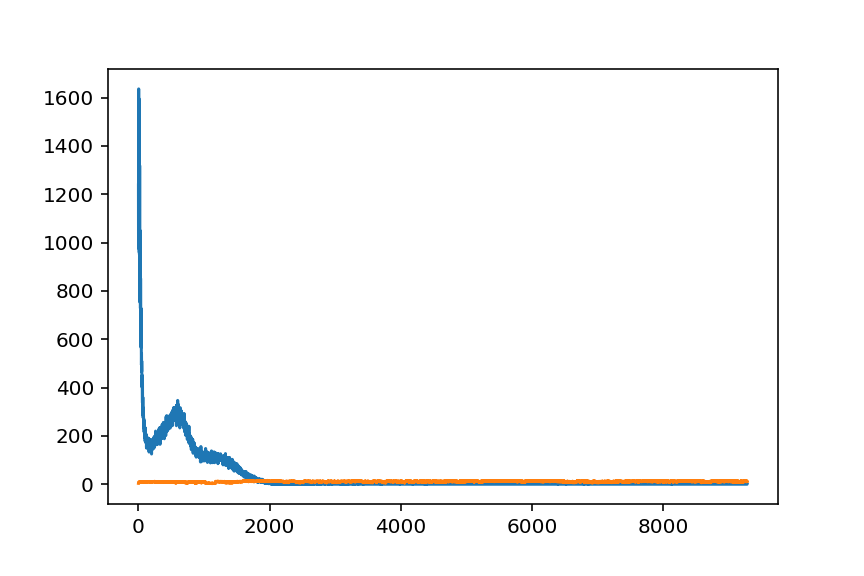

In [63]:
fig,ax = plt.subplots(1,1)
ax.plot(binned_run)
ax.plot(pop_binned)

In [36]:
from scipy.stats import pearsonr

In [51]:
run = session.running_speed.velocity
run_bins = np.linspace(0, run.max(), numbins+1)
binned_run, bins = np.histogram(run, run_bins)

In [56]:
pop_binned.shape, binned_run.shape

((9278,), (9278,))

In [53]:
r, pval = pearsonr(pop_binned,binned_run)

In [54]:
r

-0.3273554249083175

In [55]:
pval

1.2229947582060813e-230